### Preface

Note that this is a contiuation of the previous NLP work. If any NLP treatments are changed, we need to update to make sure that the imported dataset reflects the latest NLP change, and is not affected by the latest change. If affected, then we need to re-label the dataset.

### Overview

Similar to the spam/ham classification exercise, the goal of this notebook is to use a supervised classification algorithm to build a model that is suitable for predicting whether attorneys need to act on a certain docket text. What was provided was the 600+ docket texts with labeled targets. Even though this is a small dataset to work with, this can be a good starting point. Steps to build a supervised classificaiton model:

1. Extract dataset from excel. Dataset contains cleaned texts and their labels. Note that NLP is not necessary as the dataset contains cleaned docket texts already.
2. Compare modeling results by performing cross validation (GridsearchCV) and optimizing the model. Remember to do validation. 
3. Save model for use in Test scenario.

### Basic Necessities

In [1]:
import pandas as pd
import numpy as np
import pickle
from collections import Counter
from ast import literal_eval
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
from wordcloud import WordCloud

In [4]:
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.base import clone
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import model_from_json

from keras import utils

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


### Import Data 1 - From Chris

In [5]:
data = pd.read_excel(r'E:\WinUser\Documents\Python Code\AI Paralegal\docket_texts\Train\DT\New Topics - Classification -5.27.2018.xlsx')
data.drop('DT Topics', axis = 1, inplace = True)
print(data.shape)
data.drop_duplicates(inplace = True, keep = 'first')
print(data.shape)
data.head()

(625, 7)
(603, 7)


,Original Docket Text,Removed unnecessary POS & vocab,Removed unnecessary POS & vocab DT,Apply Trigram Phrase Model,New Topocs,Action [Y/N],If Y
0,(REDACTED) RULE 56.1 STATEMENT. Document filed...,"['rule .', 'document file .']","['rule .', 'document file .']","['rule .', 'document file .']",System Msg,N,NaN
1,***DELETED DOCUMENT. Deleted document number 1...,"['delete document .', 'delete document number ...","['delete document .', 'delete document number ...","['delete document .', 'delete document number ...",System Msg,N,NaN
2,***DELETED DOCUMENT. Deleted document number 2...,"['delete document .', 'delete document number ...","['delete document .', 'delete document number ...","['delete document .', 'delete document number ...",System Msg,N,NaN
3,***NOTE TO ATTORNEY OF NON-ECF CASE ERROR. Not...,"['note nonecf error .', 'note manually refile ...","['note nonecf error .', 'note manually refile ...","['note nonecf error .', 'note manually refile ...",System Msg,N,NaN
4,***NOTE TO ATTORNEY TO RE-FILE DOCUMENT - NON-...,"['note refile document nonecf error .', 'note ...","['note refile document nonecf error .', 'note ...","['note refile document nonecf error .', 'note ...",System Msg,N,NaN


### Import Data 2 - From NLP Exercise, for comparison and trouble shooting purposes, for now

In [6]:
#because there were some changes, I wanted to make sure that Chris' feedback stayed the same
filename = 'docket_texts/train/DT/basic_cleaned.pickle'
with open(filename, 'rb') as handle:
    train_cleaned_df = pickle.load(handle)

In [7]:
print(train_cleaned_df[train_cleaned_df['cleaned'] != ''].shape)
print(train_cleaned_df[train_cleaned_df['cleaned'] != ''][['Original Docket Text', 'phrases']].drop_duplicates().shape)
train_cleaned_df[train_cleaned_df['cleaned'] != ''].head()

(618, 13)
(596, 2)


,Original Docket Text,Organization Portion,Name Portion,Identifying Org and Name,Stripped Org and Name,normalized,tokenize,nostop,DT Topics,Removed unnecessary POS & vocab DT,lemmed,phrases,cleaned
1,Case assigned to Judge Ann M Donnelly and Magi...,Individual Practices of the assigned Judges,Ann M Donnelly Vera M. Scanlon Bowens Priscilla,Case assigned to Judge -NAME- -NAME- -NAME- an...,Case assigned to Judge and Magistrate Judge . ...,case assigned to judge and magistrate judge pl...,"[case, assigned, to, judge, and, magistrate, j...","[case, assigned, judge, magistrate, judge, ple...",,"[case, assigned, judge, magistrate, judge, ple...",case assign judge magistrate judge please down...,case_assign judge magistrate_judge please_down...,case_assign magistrate_judge please_download_r...
5,This attorney case opening filing has been che...,,Bowens Priscilla,This attorney case opening filing has been che...,This attorney case opening filing has been che...,this attorney case opening filing has been che...,"[this, attorney, case, opening, filing, has, b...","[attorney, case, opening, filing, checked, qua...",,"[attorney, case, opening, filing, checked, qua...",attorney case open file check quality control ...,attorney case_open file check_quality_control_...,case_open check_quality_control_see attachment...
15,Proposed Scheduling Order by LG Capital Fundin...,LG Capital Funding,Kevin,Proposed Scheduling Order by -ORG- -ORG- -ORG-...,"Proposed Scheduling Order by , LLC ( Kehrli , ...",proposed scheduling order by llc kehrli entere...,"[proposed, scheduling, order, by, llc, kehrli,...","[proposed, scheduling, order, llc, kehrli, ent...",,"[proposed, scheduling, order, llc, kehrli, ent...",propose schedule order llc kehrli enter date,propose schedule order llc_kehrli enter date,propose schedule order llc_kehrli
16,Letter re: Proposed Scheduling Order by LG Cap...,LG Capital Funding,Kevin,Letter re : Proposed Scheduling Order by -ORG-...,"Letter re : Proposed Scheduling Order by , LLC...",letter re proposed scheduling order by llc att...,"[letter, re, proposed, scheduling, order, by, ...","[letter, proposed, scheduling, order, llc, att...",,"[letter, proposed, scheduling, order, llc, att...",letter propose schedule order llc attachments ...,letter propose schedule order llc attachments_...,letter propose schedule order attachments_exhi...
59,ORDER directing Plaintiff to respond to Defend...,,Vera M. Scanlon ( Gersovitz Ryan,ORDER directing Plaintiff to respond to Defend...,ORDER directing Plaintiff to respond to Defend...,order directing plaintiff to respond to defend...,"[order, directing, plaintiff, to, respond, to,...","[order, directing, plaintiff, respond, defenda...",,"[order, directing, plaintiff, respond, defenda...",order direct plaintiff respond defendant lette...,order direct plaintiff respond defendant lette...,order respond letter order magistrate_judge


In [8]:
df = data[['Original Docket Text', 'New Topocs', 'Action [Y/N]', 'If Y']].merge(train_cleaned_df[['Original Docket Text', 'DT Topics', 'phrases']], on = 'Original Docket Text', how = 'outer')
df.drop_duplicates().shape

(3205, 6)

In [9]:
df[(df['DT Topics'] != '') & (df['New Topocs'].isnull() == False)].drop_duplicates().to_csv('test.csv', index = False)

In [10]:
df[(df['phrases'] != '') & (df['New Topocs'].isnull() == True)].drop_duplicates().to_csv('test.csv', index = False)

In [11]:
df.drop_duplicates().to_csv('test.csv', index = False)

In [12]:
df['Original Docket Text'].iloc[338]

'ORDER: By October 7, 2011, the parties shall exchange proposed deposition witness lists. Plaintiff may depose no more than thirty witnesses, and Defendant no more than fifteen witnesses, for eight hours each. Depositions shall not be taken before November 1, 2011, as further set forth on this order. (Status Conference set for 10/4/2011 at 02:00 PM and 2/8/2012 at 02:00 PM in Courtroom 20A, 500 Pearl Street, New York, NY 10007 before Judge Paul G. Gardephe.) (Signed by Magistrate Judge Frank Maas on 9/12/2011) Copies Sent By Chambers. (ab) (Entered: 09/13/2011)'

### Bookmark

In [13]:
#According to Chris' input, add the following. Not sure what this was for...:
text1 = "MEMO ENDORSEMENT on re: (37 in 1:04-cv-07900-LAK, (72 in 1:03-cv-02387-LAK) MOTION for an entry of an order in the form attached hereto as Exhibit 1 attached to this motion. ENDORSED: Granted. So Ordered (Signed by Judge Lewis A. Kaplan on 7/29/2008) Filed In Associated Cases: 1:03-cv-02387-LAK, 1:04-cv-07900-LAK(jfe) (Entered: 07/29/2008)"
text2 = "DECISION and ORDER: Pursuant to 28 U.S.C. § 1404, this Court hereby transfers this matter to the United States District Court for the Southern District of New York. Case transferred to District of Southern District of New York. Original file, certified copy of transfer order, and docket sheet sent. ALL FILINGS ARE TO BE MADE IN THE TRANSFER COURT, DO NOT DOCKET TO THIS CASE.. So Ordered by Judge William F. Kuntz, II on 4/17/2017. (Tavarez, Jennifer) [Transferred from New York Eastern on 4/28/2017.] (Entered: 04/19/2017)"
text3 = "***NOTE TO ATTORNEY TO RE-FILE DOCUMENT - NON-ECF DOCUMENT ERROR. Note to Attorney Gary A. Bornstein: Document No. 329 is an Exhibit. This document is not filed via ECF. Exhibits are ONLY filed as attachments to a supporting or opposing document. (ldi) (Entered: 01/02/2013)"

In [14]:
print(data[data['Original Docket Text'] == text1]['Action [Y/N]'])
print(data[data['Original Docket Text'] == text2]['Action [Y/N]'])
print(data[data['Original Docket Text'] == text3]['Action [Y/N]'])

242    Y
Name: Action [Y/N], dtype: object
624    Y
Name: Action [Y/N], dtype: object
6    Y
Name: Action [Y/N], dtype: object


There are some categorical imbalance. May want to deal with this

In [15]:
#some info about the training dataset
print(data['New Topocs'].unique())
print(data['Action [Y/N]'].unique())
print(data['If Y'].unique())
print(data['Action [Y/N]'].value_counts())

['System Msg' 'Summary Judgment Filing' 'Affidavit' "Court's Response"
 'Letter to Court' 'Application' "Court's Order" "Court's Order "
 'Trial Filing' 'Brief' 'Motion' 'Discovery' 'Discover' nan
 'Default Judgment' 'Transcript']
['N' 'Y']
[nan 'Triage']
Y    381
N    222
Name: Action [Y/N], dtype: int64


In [16]:
print(data['New Topocs'].value_counts())
data.shape

System Msg                 223
Court's Order              107
Letter to Court             95
Summary Judgment Filing     52
Transcript                  47
Motion                      31
Discovery                   17
Trial Filing                13
Affidavit                    6
Brief                        4
Default Judgment             2
Court's Response             1
Application                  1
Discover                     1
Court's Order                1
Name: New Topocs, dtype: int64


(603, 7)

In [17]:
# The only action to take right now is to triage
print(data['If Y'].value_counts())
data.shape

Triage    377
Name: If Y, dtype: int64


(603, 7)

In [18]:
# I don't think I need this
def text_treatment(some_list):
    text = ' '.join(literal_eval(some_list))
    text = text.replace('.', '')
    text = ' '.join(text.split())
    return text

In [19]:
data.rename(columns = {'Apply Trigram Phrase Model': 'feature'}, inplace = True)
#data.feature = data.feature.apply(text_treatment) #don't need
data['label'] = data['Action [Y/N]'].apply(lambda x: 1 if x == 'Y' else 0 )
print(data['label'].value_counts())
data.shape

1    381
0    222
Name: label, dtype: int64


(603, 8)

In [20]:
data.feature

0                          ['rule .', 'document file .']
1      ['delete document .', 'delete document number ...
2      ['delete document .', 'delete document number ...
3      ['note nonecf error .', 'note manually refile ...
4      ['note refile document nonecf error .', 'note ...
5      ['note refile document nonecf error .', 'note ...
6      ['note refile document nonecf document error ....
7                           ['propose conclusion_law .']
8      ['affidavit support motion order grant motion ...
9      ['affidavit jr. c.p.a .', 'administration .', ...
10     ['affidavit jr. c.p.a .', 'administration .', ...
11     ['affidavit support propose order permit subst...
12      ['affidavit .', 'document file alphaplus l.p..']
13     ['affidavit support motion dismiss.. document ...
14     ['amend protective order govern production exc...
15     ['amend letter_address indispensable .', 'docu...
16     ['amend letter_address propose protective orde...
17            ['amend propose_f

 ### Visualisations ... sure whynot?

In [21]:
action = data[data.label == 1]['feature']
noaction = data[data.label == 0]['feature']

In [22]:
%%time
action_words = ''
noaction_words = ''

for val in action:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        action_words = action_words + words + ' '
        
for val in noaction:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        noaction_words = noaction_words + words + ' '


Wall time: 161 ms


In [23]:
Counter(action_words.split()).most_common(10)

[("'", 870),
 ('.', 732),
 (',', 479),
 ('file', 416),
 ('[', 381),
 (']', 381),
 ('order', 202),
 ('motion', 161),
 ("'document", 139),
 ("'order", 83)]

In [24]:
# Generate a word cloud image
action_wordcloud = WordCloud(width = 600, height = 400).generate(action_words)
noaction_wordcloud = WordCloud(width = 600, height = 400).generate(noaction_words)

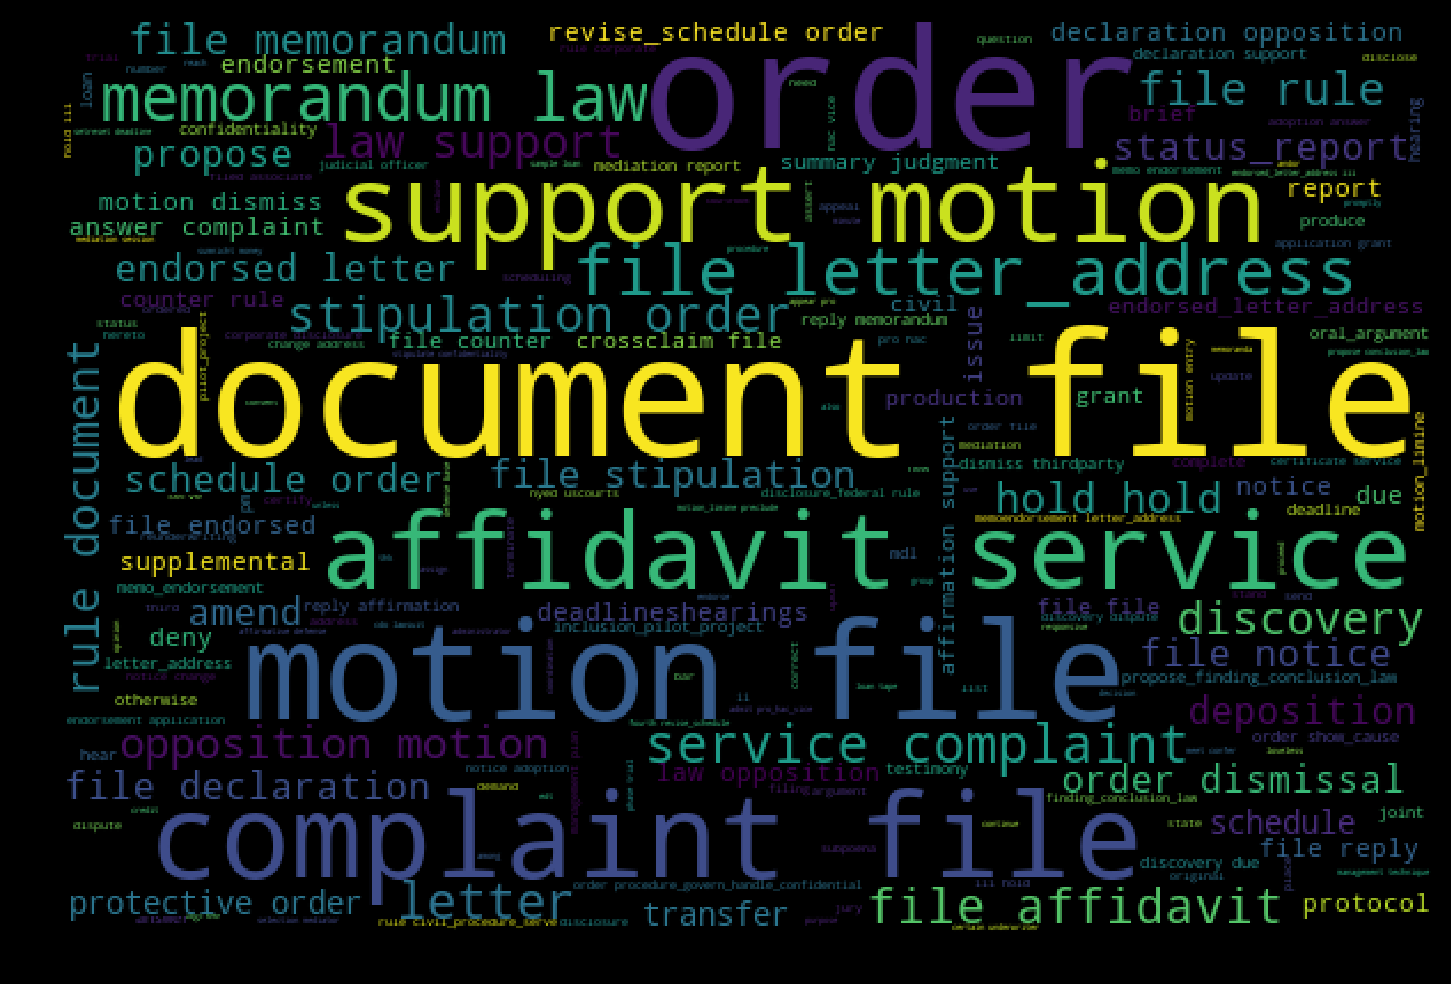

In [25]:
#Action Word cloud
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(action_wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

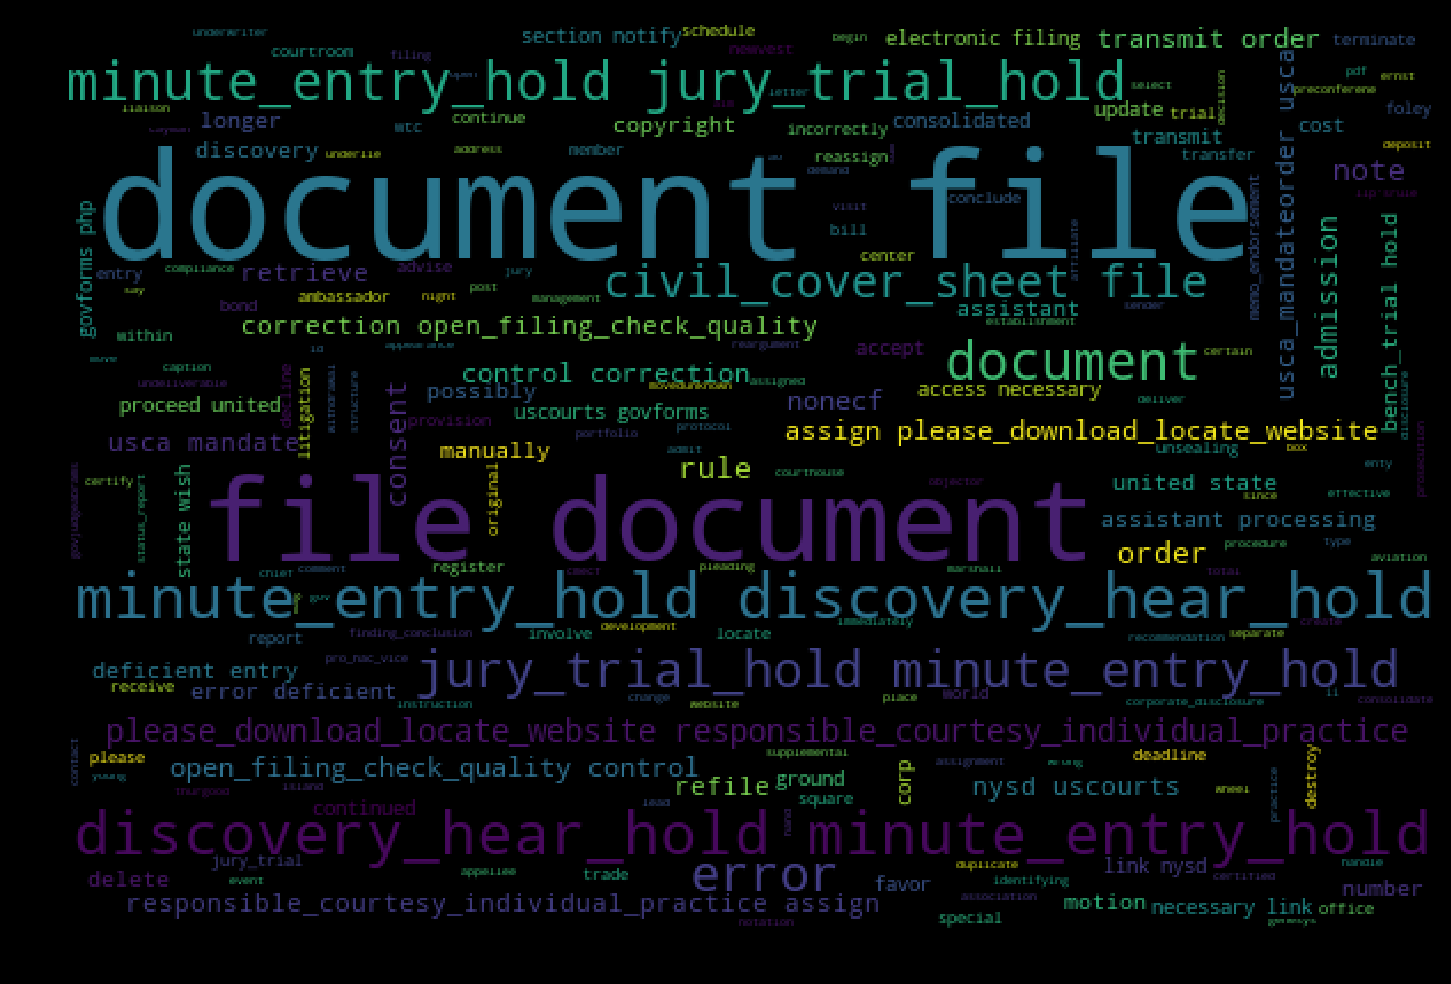

In [26]:
#No-Action Spam Word cloud
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(noaction_wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [27]:
#this is for AWS
data.to_pickle('docket_texts/Train/DT/train_docket_processed.pkl')

### Define Training and Testing data

In [28]:
#do I need to balance out the dataset??
#reference: https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
Xtrain, Xtest, ytrain, ytest = train_test_split(data.feature, data.label, test_size = 0.2, random_state = 10)

### Text Transformation. A little different from previous attempts...

In [29]:
#reference: https://www.quora.com/What-is-the-difference-between-TfidfVectorizer-and-CountVectorizer-1
CV_vect = CountVectorizer() #Convert a collection of text documents to a matrix of token counts, bag of words
TV_vect = TfidfVectorizer() #term frequency, inverse document frequency - 

CV_vect.fit(Xtrain)
TV_vect.fit(Xtrain)

#we'll need to save these
joblib.dump(CV_vect, 'docket_texts/Train/DT/CountVectorizer.pkl')
joblib.dump(TV_vect, 'docket_texts/Train/DT/TfidfVectorizer.pkl')

max_words = len(CV_vect.get_feature_names())
Keras_tokenize = Tokenizer(num_words = max_words, char_level = False)
Keras_tokenize.fit_on_texts(Xtrain)

joblib.dump(Keras_tokenize, 'docket_texts/Train/DT/Keras_tokenize.pkl')

['docket_texts/Train/DT/Keras_tokenize.pkl']

In [30]:
print('CountVectorizer feature length: {}'.format(len(CV_vect.get_feature_names())))
print('TfidfVectorizer feature length: {}'.format(len(TV_vect.get_feature_names())))

CountVectorizer feature length: 850
TfidfVectorizer feature length: 850


In [31]:
#transform the train and test data into vectors, according to countvectorizer results
CV_vect = joblib.load('docket_texts/Train/DT/CountVectorizer.pkl') 
Xtrain_CV = CV_vect.transform(Xtrain)
Xtest_CV = CV_vect.transform(Xtest)

TV_vect = joblib.load('docket_texts/Train/DT/TfidfVectorizer.pkl') 
Xtrain_TV = TV_vect.transform(Xtrain)
Xtest_TV = TV_vect.transform(Xtest)

Keras_tokenize = joblib.load('docket_texts/Train/DT/Keras_tokenize.pkl') 
Xtrain_Keras = Keras_tokenize.texts_to_matrix(Xtrain)
Xtest_Keras = Keras_tokenize.texts_to_matrix(Xtest)

In [32]:
#print(Xtrain_CV.toarray()[0])
#print(Xtrain_TV.toarray()[0])
print(Xtrain_CV.toarray().shape)
print(Xtrain_TV.toarray().shape)
print(Xtrain_Keras.shape)

(482, 850)
(482, 850)
(482, 850)


In [33]:
#this is for keras only
num_classes = 2
ytrain_Keras = utils.to_categorical(ytrain, num_classes)
ytest_Keras = utils.to_categorical(ytest, num_classes)

In [34]:
print(ytrain_Keras[:10])
print(ytrain[:10])

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
285    1
438    0
620    0
246    1
12     1
1      0
297    1
470    1
606    1
110    1
Name: label, dtype: int64


### Machine Learning models - Default Hyperparameters

In [35]:
prediction = dict()
accuracy_scores = dict()

#### Gaussian Naive Bayes doesn't work with the dataset that we have

#### Multinomial Naive Bayes

In [36]:
%time
#remember to change 2 things: the id and the model algo
id = 'MNB'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = MultinomialNB()
    model.fit(Xtrain, ytrain)
    prediction[id + ' ' + label] = model.predict(Xtest)
    accuracy_scores[id + ' ' + label] = accuracy_score(ytest, prediction[id + ' ' + label])

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 
#AWS c5.large time: 0 ns

Wall time: 0 ns
updated accuracy scores: [('MNB CV', 0.8016528925619835), ('MNB Keras', 0.7851239669421488), ('MNB TV', 0.7520661157024794)]


#### Bernoulli Naive Bayes

In [37]:
%time
#remember to change 2 things: the id and the model algo
id = 'BNB'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = BernoulliNB()
    model.fit(Xtrain, ytrain)
    prediction[id + ' ' + label] = model.predict(Xtest)
    accuracy_scores[id + ' ' + label] = accuracy_score(ytest, prediction[id + ' ' + label])

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 
#AWS c5.large time: 0 ns

Wall time: 0 ns
updated accuracy scores: [('BNB TV', 0.9338842975206612), ('BNB CV', 0.9338842975206612), ('BNB Keras', 0.9008264462809917), ('MNB CV', 0.8016528925619835), ('MNB Keras', 0.7851239669421488), ('MNB TV', 0.7520661157024794)]


#### Logistic Regression

In [38]:
%time
#remember to change 2 things: the id and the model algo
id = 'LR'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = LogisticRegression()
    model.fit(Xtrain, ytrain)
    prediction[id + ' ' + label] = model.predict(Xtest)
    accuracy_scores[id + ' ' + label] = accuracy_score(ytest, prediction[id + ' ' + label])

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 
#AWS c5.large time: 0 ns

Wall time: 0 ns
updated accuracy scores: [('LR Keras', 0.9421487603305785), ('BNB TV', 0.9338842975206612), ('BNB CV', 0.9338842975206612), ('LR CV', 0.9256198347107438), ('BNB Keras', 0.9008264462809917), ('LR TV', 0.8842975206611571), ('MNB CV', 0.8016528925619835), ('MNB Keras', 0.7851239669421488), ('MNB TV', 0.7520661157024794)]


#### KNN Classifier

In [39]:
%time
#remember to change 2 things: the id and the model algo
id = 'KNN'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = KNeighborsClassifier()
    model.fit(Xtrain, ytrain)
    prediction[id + ' ' + label] = model.predict(Xtest)
    accuracy_scores[id + ' ' + label] = accuracy_score(ytest, prediction[id + ' ' + label])

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key=lambda x: x[1], reverse=True)))
#CPU time: 
#AWS c5.large time: 0 ns

Wall time: 0 ns
updated accuracy scores: [('LR Keras', 0.9421487603305785), ('BNB TV', 0.9338842975206612), ('BNB CV', 0.9338842975206612), ('LR CV', 0.9256198347107438), ('BNB Keras', 0.9008264462809917), ('LR TV', 0.8842975206611571), ('KNN CV', 0.8099173553719008), ('MNB CV', 0.8016528925619835), ('KNN Keras', 0.8016528925619835), ('MNB Keras', 0.7851239669421488), ('KNN TV', 0.7520661157024794), ('MNB TV', 0.7520661157024794)]


#### SVM Classifier

In [40]:
%time
#remember to change 2 things: the id and the model algo
id = 'SVM'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = SVC()
    model.fit(Xtrain, ytrain)
    prediction[id + ' ' + label] = model.predict(Xtest)
    accuracy_scores[id + ' ' + label] = accuracy_score(ytest, prediction[id + ' ' + label])

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key=lambda x: x[1], reverse=True)))
#CPU time: 
#AWS c5.large time: 0 ns

Wall time: 0 ns
updated accuracy scores: [('LR Keras', 0.9421487603305785), ('BNB TV', 0.9338842975206612), ('BNB CV', 0.9338842975206612), ('LR CV', 0.9256198347107438), ('BNB Keras', 0.9008264462809917), ('LR TV', 0.8842975206611571), ('KNN CV', 0.8099173553719008), ('MNB CV', 0.8016528925619835), ('KNN Keras', 0.8016528925619835), ('MNB Keras', 0.7851239669421488), ('KNN TV', 0.7520661157024794), ('MNB TV', 0.7520661157024794), ('SVM CV', 0.5785123966942148), ('SVM TV', 0.5785123966942148), ('SVM Keras', 0.5785123966942148)]


#### Ensemble Classifier: Random Forest

In [41]:
%time
#remember to change 2 things: the id and the model algo
id = 'RF'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = RandomForestClassifier()
    model.fit(Xtrain, ytrain)
    prediction[id + ' ' + label] = model.predict(Xtest)
    accuracy_scores[id + ' ' + label] = accuracy_score(ytest, prediction[id + ' ' + label])

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 
#AWS c5.large time: 0 ns

Wall time: 0 ns
updated accuracy scores: [('LR Keras', 0.9421487603305785), ('BNB TV', 0.9338842975206612), ('BNB CV', 0.9338842975206612), ('LR CV', 0.9256198347107438), ('RF TV', 0.9256198347107438), ('RF Keras', 0.9173553719008265), ('RF CV', 0.9173553719008265), ('BNB Keras', 0.9008264462809917), ('LR TV', 0.8842975206611571), ('KNN CV', 0.8099173553719008), ('MNB CV', 0.8016528925619835), ('KNN Keras', 0.8016528925619835), ('MNB Keras', 0.7851239669421488), ('KNN TV', 0.7520661157024794), ('MNB TV', 0.7520661157024794), ('SVM CV', 0.5785123966942148), ('SVM TV', 0.5785123966942148), ('SVM Keras', 0.5785123966942148)]


#### Ensemble Classifier: AdaBoost

In [42]:
%time
#remember to change 2 things: the id and the model algo
id = 'AB'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = AdaBoostClassifier()
    model.fit(Xtrain, ytrain)
    prediction[id + ' ' + label] = model.predict(Xtest)
    accuracy_scores[id + ' ' + label] = accuracy_score(ytest, prediction[id + ' ' + label])

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 
#AWS c5.large time: 0 ns

Wall time: 0 ns
updated accuracy scores: [('AB Keras', 0.9504132231404959), ('LR Keras', 0.9421487603305785), ('BNB TV', 0.9338842975206612), ('BNB CV', 0.9338842975206612), ('LR CV', 0.9256198347107438), ('RF TV', 0.9256198347107438), ('RF Keras', 0.9173553719008265), ('AB CV', 0.9173553719008265), ('RF CV', 0.9173553719008265), ('AB TV', 0.9090909090909091), ('BNB Keras', 0.9008264462809917), ('LR TV', 0.8842975206611571), ('KNN CV', 0.8099173553719008), ('MNB CV', 0.8016528925619835), ('KNN Keras', 0.8016528925619835), ('MNB Keras', 0.7851239669421488), ('KNN TV', 0.7520661157024794), ('MNB TV', 0.7520661157024794), ('SVM CV', 0.5785123966942148), ('SVM TV', 0.5785123966942148), ('SVM Keras', 0.5785123966942148)]


#### XGBoost

In [43]:
%time
#remember to change 2 things: the id and the model algo
id = 'XGB'
for Xtrain, Xtest, label in zip([Xtrain_CV.toarray(), Xtrain_TV.toarray(), Xtrain_Keras], 
                                [Xtest_CV.toarray(), Xtest_TV.toarray(), Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = XGBClassifier()
    model.fit(Xtrain, ytrain)
    prediction[id + ' ' + label] = model.predict(Xtest)
    accuracy_scores[id + ' ' + label] = accuracy_score(ytest, prediction[id + ' ' + label])

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 
#AWS c5.large time: 0 ns

Wall time: 0 ns


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


updated accuracy scores: [('AB Keras', 0.9504132231404959), ('LR Keras', 0.9421487603305785), ('XGB Keras', 0.9338842975206612), ('BNB CV', 0.9338842975206612), ('BNB TV', 0.9338842975206612), ('LR CV', 0.9256198347107438), ('RF TV', 0.9256198347107438), ('RF Keras', 0.9173553719008265), ('AB CV', 0.9173553719008265), ('RF CV', 0.9173553719008265), ('XGB TV', 0.9090909090909091), ('AB TV', 0.9090909090909091), ('BNB Keras', 0.9008264462809917), ('XGB CV', 0.8925619834710744), ('LR TV', 0.8842975206611571), ('KNN CV', 0.8099173553719008), ('MNB CV', 0.8016528925619835), ('KNN Keras', 0.8016528925619835), ('MNB Keras', 0.7851239669421488), ('KNN TV', 0.7520661157024794), ('MNB TV', 0.7520661157024794), ('SVM CV', 0.5785123966942148), ('SVM Keras', 0.5785123966942148), ('SVM TV', 0.5785123966942148)]


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Keras

In [44]:
def keras_prelim():
    model = Sequential()
    model.add(Dense(512, input_shape = (Xtrain_CV.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [54]:
id = 'Keras'

for Xtrain, Xtest, label in zip([Xtrain_CV.toarray(), Xtrain_TV.toarray(), Xtrain_Keras], 
                                [Xtest_CV.toarray(), Xtest_TV.toarray(), Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    batch_size = 10
    epochs = 10
    model = keras_prelim()
    model.fit(Xtrain, ytrain_Keras, batch_size = batch_size, epochs = epochs, verbose = 1, validation_split = 0.1)

    # Evaluate the accuracy of our trained model
    score = model.evaluate(Xtest, ytest_Keras, batch_size = batch_size, verbose = 1)
    print('\nTest score (loss value:', score[0])
    print('Test accuracy:', score[1])

    prediction[id + ' ' + label] =  np.argmax(model.predict(Xtest), axis = 1)
    accuracy_scores[id + ' ' + label] = accuracy_score(ytest, prediction[id + ' ' + label])

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key = lambda x: x[1], reverse = True)))

#CPU time: 
#AWS c5.large time: 0 ns

Train on 433 samples, validate on 49 samples
Epoch 1/10
433/433 [==============================] - 0s - loss: 0.5213 - acc: 0.7390 - val_loss: 0.3530 - val_acc: 0.8980
Epoch 2/10
433/433 [==============================] - 0s - loss: 0.1957 - acc: 0.9607 - val_loss: 0.2792 - val_acc: 0.9184
Epoch 3/10
433/433 [==============================] - 0s - loss: 0.0894 - acc: 0.9746 - val_loss: 0.2839 - val_acc: 0.9184
Epoch 4/10
433/433 [==============================] - 0s - loss: 0.0750 - acc: 0.9769 - val_loss: 0.3241 - val_acc: 0.9184
Epoch 5/10
433/433 [==============================] - 0s - loss: 0.0696 - acc: 0.9792 - val_loss: 0.3603 - val_acc: 0.9184
Epoch 6/10
433/433 [==============================] - 0s - loss: 0.0769 - acc: 0.9769 - val_loss: 0.3650 - val_acc: 0.9184
Epoch 7/10
433/433 [==============================] - 0s - loss: 0.0637 - acc: 0.9792 - val_loss: 0.2922 - val_acc: 0.9184
Epoch 8/10
433/433 [==============================] - 0s - loss: 0.0671 - acc: 0.9792 - val_lo

### Parameter Tuning using GridSearchCV
Let's pick the top algos/dataset treatment, and see if GridSearchCV can improve the accuracies:
1. AB Keras: 0.9504
2. LR Keras: 0.9421
3. Keras CV: 0.9338
4. XGB Keras: 0.9338
5. Keras TV: 0.9338

The top 3 algos are Keras, AdaBoost, Logistic Regression. Let's see if we can tune them to perform better:

#### setup a gridsearch pipeline

In [51]:
def gridsearch(model, param_grid, cvs, X, y, plot = False):

    acc_by_cv = []
    print('selecting best cv parameter:')
    for cv in cvs:
        cloned_model = clone(model, safe = True)
        grid = GridSearchCV(cloned_model, param_grid = param_grid, n_jobs = 4, cv = cv)
        grid.fit(X, y)
        acc_by_cv.append(grid.best_score_)
        print(cv, ': ')
        print(grid.best_score_) #{'ABC': 0.92, 'KNNC': 0.8, 'LR': 0.928, 'MNB': 0.848, 'RFC': 0.944}
        print(grid.best_estimator_)
    
    best_cv = cvs[np.argmax(acc_by_cv)]
    print('\nbest cv: ', best_cv)
    
    cloned_model = clone(model, safe = True)
    grid = GridSearchCV(cloned_model, param_grid = param_grid, n_jobs = 4, cv = best_cv)
    grid.fit(X, y)
    print(grid.best_score_) #{'ABC': 0.92, 'KNNC': 0.8, 'LR': 0.928, 'MNB': 0.848, 'RFC': 0.944}
    print(grid.best_estimator_)
    print(grid.grid_scores_)
    
    if plot:
        plt.plot(cvs, acc_by_cv)
        plt.show()
        
    return grid.best_estimator_, pd.DataFrame(grid.grid_scores_), best_cv

### 3. RandomForestClassifier

selecting best cv parameter:
2 : 
0.9294605809128631
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=55, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
3 : 
0.9294605809128631
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=60, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
4 : 
0.946058091286307
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_

23 : 
0.9377593360995851
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
24 : 
0.941908713692946
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
25 : 
0.9356846473029046
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            mi

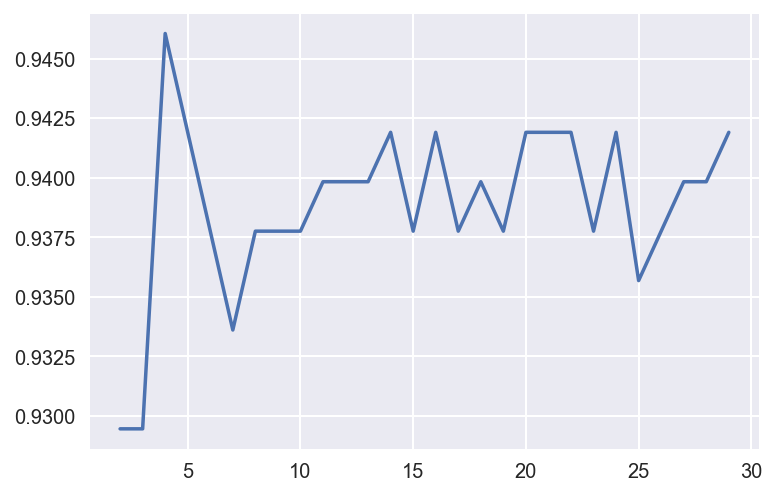

selecting best cv parameter:
2 : 
0.921161825726141
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
3 : 
0.9377593360995851
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=60, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
4 : 
0.9315352697095436
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_

23 : 
0.9356846473029046
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=35, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
24 : 
0.9377593360995851
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
25 : 
0.9398340248962656
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            m

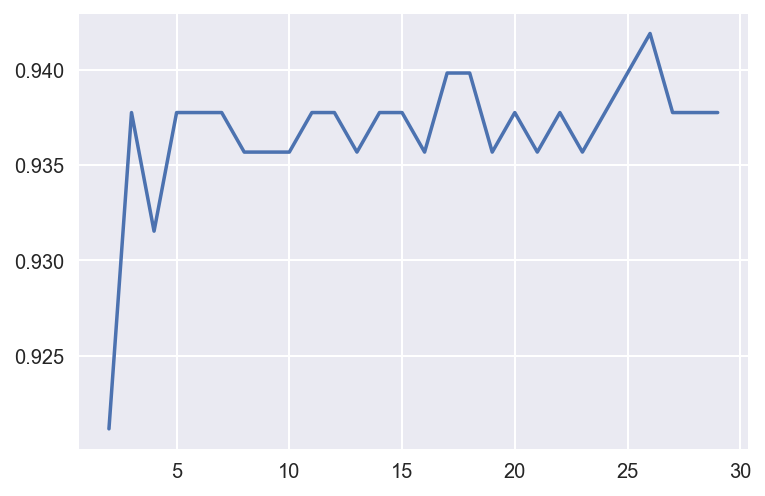

selecting best cv parameter:
2 : 
0.9128630705394191
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=90, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
3 : 
0.941908713692946
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=90, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
4 : 
0.941908713692946
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_n

23 : 
0.9481327800829875
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
24 : 
0.950207468879668
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
25 : 
0.9481327800829875
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            mi

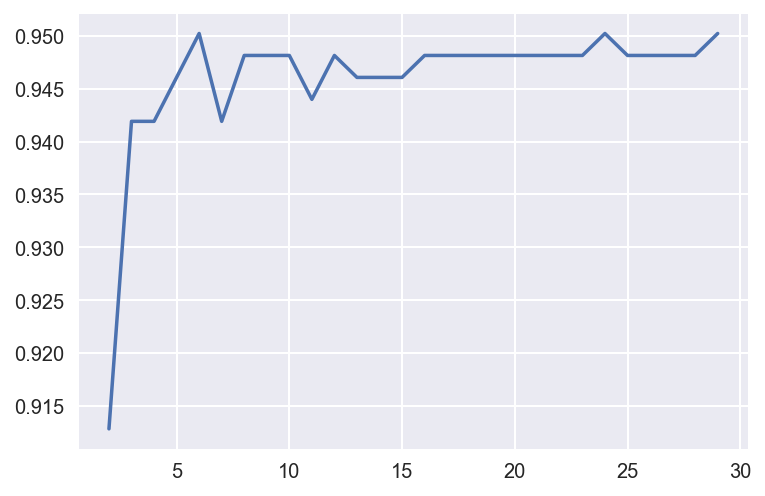

algo elapsed: 10666.576189994812 seconds


In [132]:
t0 = time()
cvs = range(2, 30)
RF_dict = {}
param_grid = {'n_estimators': range(5, 105, 5),
              'max_features': ['auto', 'sqrt', 'log2', None]}
for Xtrain, label in zip([Xtrain_Keras, Xtrain_CV, Xtrain_TV], ['Keras', 'CV', 'TV']):
    model = RandomForestClassifier(n_jobs = 4)
    RF_dict['opt model ' + label], RF_dict['summary df ' + label], RF_dict['cv ' + label] = gridsearch(model, param_grid, cvs, Xtrain, ytrain, plot = True)

print('algo elapsed: {} seconds'.format(time() - t0))
#CPU time: 10666.576189994812 seconds
#AWS c5.large time: 

In [133]:
print('top score was 0.944')
for key in ['CV', 'TV', 'Keras']:
    print('accuracy scores for {} is {}'.format(key, RF_dict['summary df ' + key]['mean_validation_score'].iloc[RF_dict['summary df ' + key]['mean_validation_score'].argmax()]))
    print('parameters for model {} is {}'.format(key, RF_dict['summary df ' + key]['parameters'].iloc[RF_dict['summary df ' + key]['mean_validation_score'].argmax()]))

top score was 0.944
accuracy scores for CV is 0.9377593360995851
parameters for model CV is {'n_estimators': 5, 'max_features': 'log2'}
accuracy scores for TV is 0.9481327800829875
parameters for model TV is {'n_estimators': 50, 'max_features': 'log2'}
accuracy scores for Keras is 0.9336099585062241
parameters for model Keras is {'n_estimators': 50, 'max_features': 'auto'}


|Dataset|Best CV|Best Accuracy|Parameters|
|-|-|-|-|
|Xtrain_Keras|4|93.36%|n_estimator = 50, max_features = 'auto'|
|Xtrain_CV|26|93.77%|n_estimator = 5, max_features = 'log2'|
|Xtrain_TV|6|94.81%|n_estimator = 50, max_features = 'log2'|

Turns out using RF, we can achieve 94.81% accuracy with TFIDF, which is also an improvement over the best model in the prelim assessment.

We are also seeing accuracies trending up for higher CVs


### 2. AdaBoost

selecting best cv parameter:
2 : 
0.9377593360995851
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=40, random_state=None)
3 : 
0.9356846473029046
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=55, random_state=None)
4 : 
0.9336099585062241
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=45, random_state=None)
5 : 
0.9398340248962656
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=70, random_state=None)
6 : 
0.941908713692946
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=65, random_state=None)
7 : 
0.9398340248962656
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=80, random_state=None)
8 : 
0.9377593360995851
AdaBoostClassifier(algorithm='SAMME.R', base_estim

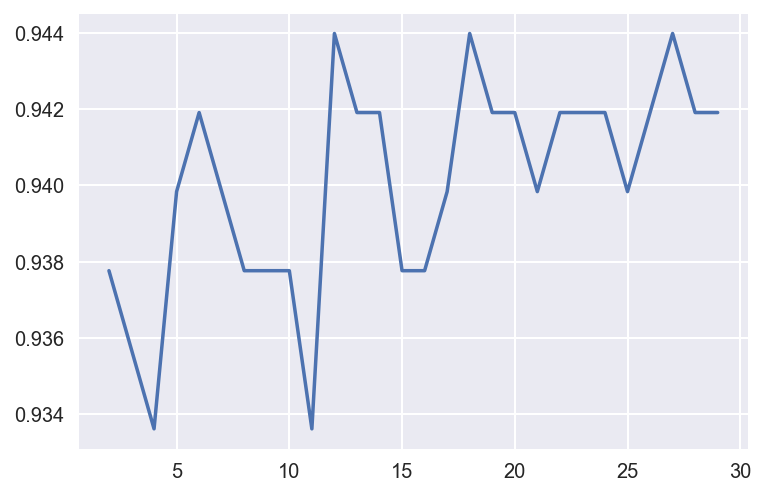

selecting best cv parameter:
2 : 
0.9273858921161826
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=75, random_state=None)
3 : 
0.9336099585062241
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=100, random_state=None)
4 : 
0.9273858921161826
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=80, random_state=None)
5 : 
0.9336099585062241
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=90, random_state=None)
6 : 
0.9377593360995851
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=70, random_state=None)
7 : 
0.9315352697095436
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=70, random_state=None)
8 : 
0.9356846473029046
AdaBoostClassifier(algorithm='SAMME.R', base_estimat

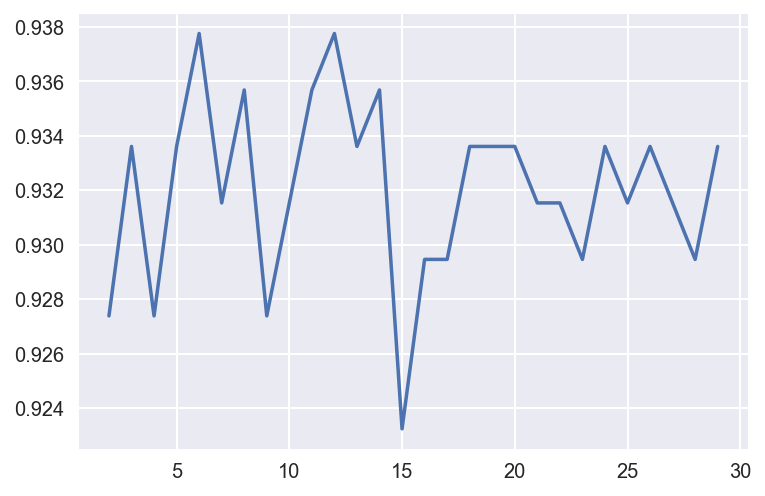

selecting best cv parameter:
2 : 
0.921161825726141
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=100, random_state=None)
3 : 
0.9336099585062241
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=85, random_state=None)
4 : 
0.9273858921161826
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=100, random_state=None)
5 : 
0.9273858921161826
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=90, random_state=None)
6 : 
0.9336099585062241
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=95, random_state=None)
7 : 
0.9273858921161826
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=50, random_state=None)
8 : 
0.9294605809128631
AdaBoostClassifier(algorithm='SAMME.R', base_est

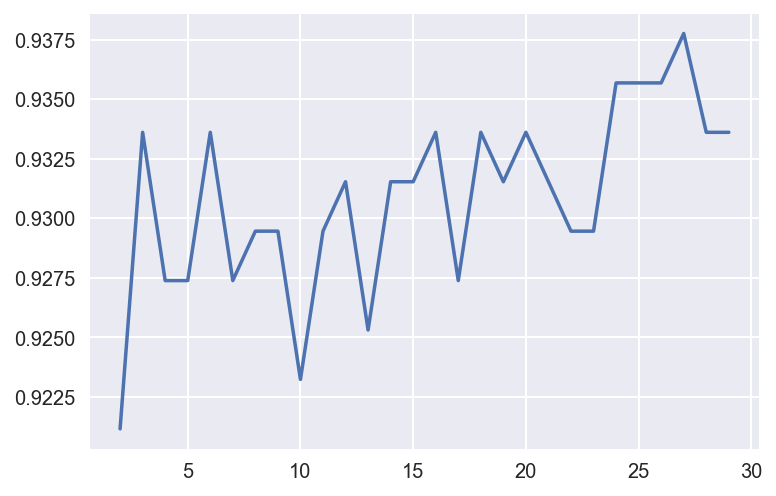

algo elapsed: 7522.845176935196 seconds


In [134]:
t0 = time()
cvs = range(2, 30)
AB_dict = {}
param_grid = {'n_estimators': range(5, 105, 5),
              'learning_rate': [0.01, 0.1, 0.5, 1, 2, 10, 100]}
for Xtrain, label in zip([Xtrain_Keras, Xtrain_CV, Xtrain_TV], ['Keras', 'CV', 'TV']):
    model = AdaBoostClassifier()
    AB_dict['opt model ' + label], AB_dict['summary df ' + label], AB_dict['cv ' + label] = gridsearch(model, param_grid, cvs, Xtrain, ytrain, plot = True)

print('algo elapsed: {} seconds'.format(time() - t0))
#CPU time: 7522.84
#AWS c5.large time: 

In [135]:
print('top score was 0.944')
for key in ['CV', 'TV', 'Keras']:
    print('accuracy scores for {} is {}'.format(key, AB_dict['summary df ' + key]['mean_validation_score'].iloc[AB_dict['summary df ' + key]['mean_validation_score'].argmax()]))
    print('parameters for model {} is {}'.format(key, AB_dict['summary df ' + key]['parameters'].iloc[AB_dict['summary df ' + key]['mean_validation_score'].argmax()]))

top score was 0.944
accuracy scores for CV is 0.9377593360995851
parameters for model CV is {'n_estimators': 70, 'learning_rate': 0.5}
accuracy scores for TV is 0.9377593360995851
parameters for model TV is {'n_estimators': 60, 'learning_rate': 1}
accuracy scores for Keras is 0.9439834024896265
parameters for model Keras is {'n_estimators': 65, 'learning_rate': 0.5}


|Dataset|Best CV|Best Accuracy|Parameters|
|-|-|-|-|
|Xtrain_Keras|12|94.40%|n_estimator = 65, learning_rate = 0.5|
|Xtrain_CV|6|93.78%|n_estimator = 70, learning_rate = 0.5|
|Xtrain_TV|27|93.78%|n_estimator = 60, learning_rate = 1|

Turns out the optimized AB didn't beat RF.

We are also seeing accuracies trending up for higher CVs

### 1. Keras (Deep Learning)

Optimizing Neural Network is a little bit tricky. As we can only use one dataset, we'll test out different deep network structures. Also, this takes really really long time to optimize. We might need to move this to AWS to try out.

In [60]:
def keras1(input_shape):
    model = Sequential()
    model.add(Dense(1024, input_shape = (input_shape, )))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

def keras2(optimizer):
    model = Sequential()
    model.add(Dense(512, input_shape = (Xtrain_Keras.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

def keras3(optimizer):
    model = Sequential()
    model.add(Dense(512, input_shape = (Xtrain_Keras.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

def keras4(optimizer):
    model = Sequential()
    model.add(Dense(1024, input_shape = (Xtrain_Keras.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

def keras5(optimizer):
    model = Sequential()
    model.add(Dense(512, input_shape = (Xtrain_Keras.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

In [65]:
Xtrain = Xtrain_CV.toarray()
param_grid = {'batch_size': [10, 20],
              'epochs': [10, 20]}

model = KerasClassifier(build_fn = keras1(Xtrain.shape[1]), verbose = 1)
grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = 4)
grid_result = grid.fit(Xtrain, ytrain_Keras)
print(grid_result.best_params_)

TypeError: Cannot serialize socket object

850

In [ ]:
t0 = time()
Keras1_dict = {}


#for Xtrain, label in zip([Xtrain_CV.toarray(), Xtrain_TV.toarray(), Xtrain_Keras], ['CV', 'TV', 'Keras']):
for Xtrain, Xtest, label in zip([Xtrain_CV.toarray(), Xtrain_TV.toarray(), Xtrain_Keras], 
                                [Xtest_CV.toarray(), Xtest_TV.toarray(), Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    
model = KerasClassifier(build_fn = keras1, verbose = 1)
Keras_dict1['opt model ' + label], Keras_dict1['summary df ' + label], Keras_dict1['cv ' + label] = keras_gridsearch(model, param_grid, Xtrain_Keras, ytrain)

print('algo elapsed: {} seconds'.format(time() - t0))
#CPU time: 
#AWS c5.large time: 

In [ ]:
id = 'Keras'

for Xtrain, Xtest, label in zip([Xtrain_CV.toarray(), Xtrain_TV.toarray(), Xtrain_Keras], 
                                [Xtest_CV.toarray(), Xtest_TV.toarray(), Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    batch_size = 10
    epochs = 10
    model = keras_prelim()
    model.fit(Xtrain, ytrain_Keras, batch_size = batch_size, epochs = epochs, verbose = 1, validation_split = 0.1)

    # Evaluate the accuracy of our trained model
    score = model.evaluate(Xtest, ytest_Keras, batch_size = batch_size, verbose = 1)
    print('\nTest score (loss value:', score[0])
    print('Test accuracy:', score[1])

    prediction[id + ' ' + label] =  np.argmax(model.predict(Xtest), axis = 1)
    accuracy_scores[id + ' ' + label] = accuracy_score(ytest, prediction[id + ' ' + label])

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key = lambda x: x[1], reverse = True)))

#CPU time: 
#AWS c5.large time: 0 ns

In [ ]:
%%time
cvs = range(2, 30)
Keras2_dict = {}
param_grid = {'batch_size': [10, 20],
              'epochs': [10, 20],
              'optimizer': ['adam', 'rmsprop']}

for Xtrain, label in zip([Xtrain_CV.toarray(), Xtrain_TV.toarray(), Xtrain_Keras], ['CV', 'TV', 'Keras']):
    model = KerasClassifier(build_fn = keras2, verbose = False)
    Keras2_dict['opt model ' + label], Keras2_dict['summary df ' + label], Keras2_dict['cv ' + label] = gridsearch(model, param_grid, cvs, Xtrain, ytrain, plot = True)
        
#CPU time: 
#AWS c5.large time: 

In [ ]:
%%time
cvs = range(2, 30)
Keras3_dict = {}
param_grid = {'batch_size': [20, 50],
              'epochs': [100, 500],
              'optimizer': ['adam', 'rmsprop']}

for Xtrain, label in zip([Xtrain_CV.toarray(), Xtrain_TV.toarray(), Xtrain_Keras], ['CV', 'TV', 'Keras']):
    model = KerasClassifier(build_fn = keras3, verbose = False)
    Keras3_dict['opt model ' + label], Keras3_dict['summary df ' + label], Keras3_dict['cv ' + label] = gridsearch(model, param_grid, cvs, Xtrain, ytrain, plot = True)
        
#CPU time: 
#AWS c5.large time: 

In [ ]:
%%time
cvs = range(2, 30)
Keras4_dict = {}
param_grid = {'batch_size': [20, 50],
              'epochs': [100, 500],
              'optimizer': ['adam', 'rmsprop']}

for Xtrain, label in zip([Xtrain_CV.toarray(), Xtrain_TV.toarray(), Xtrain_Keras], ['CV', 'TV', 'Keras']):
    model = KerasClassifier(build_fn = keras4, verbose = False)
    Keras4_dict['opt model ' + label], Keras4_dict['summary df ' + label], Keras4_dict['cv ' + label] = gridsearch(model, param_grid, cvs, Xtrain, ytrain, plot = True)
        
#CPU time: 
#AWS c5.large time: 

In [ ]:
%%time
cvs = range(2, 30)
Keras5_dict = {}
param_grid = {'batch_size': [20, 50],
              'epochs': [100, 500],
              'optimizer': ['adam', 'rmsprop']}

for Xtrain, label in zip([Xtrain_CV.toarray(), Xtrain_TV.toarray(), Xtrain_Keras], ['CV', 'TV', 'Keras']):
    model = KerasClassifier(build_fn = keras5, verbose = False)
    Keras5_dict['opt model ' + label], Keras5_dict['summary df ' + label], Keras5_dict['cv ' + label] = gridsearch(model, param_grid, cvs, Xtrain, ytrain, plot = True)
    
#CPU time: 
#AWS c5.large time: 

In [50]:
Keras_dict1 = Keras_dict

{'Keras1': [mean: 0.93400, std: 0.02691, params: {'optimizer': 'adam', 'batch_size': 20, 'epochs': 10},
  mean: 0.93000, std: 0.02864, params: {'optimizer': 'rmsprop', 'batch_size': 20, 'epochs': 10},
  mean: 0.93600, std: 0.02939, params: {'optimizer': 'adam', 'batch_size': 20, 'epochs': 100},
  mean: 0.93800, std: 0.03156, params: {'optimizer': 'rmsprop', 'batch_size': 20, 'epochs': 100},
  mean: 0.92600, std: 0.03470, params: {'optimizer': 'adam', 'batch_size': 20, 'epochs': 500},
  mean: 0.94000, std: 0.03098, params: {'optimizer': 'rmsprop', 'batch_size': 20, 'epochs': 500},
  mean: 0.93200, std: 0.02713, params: {'optimizer': 'adam', 'batch_size': 30, 'epochs': 10},
  mean: 0.93800, std: 0.02750, params: {'optimizer': 'rmsprop', 'batch_size': 30, 'epochs': 10},
  mean: 0.93600, std: 0.03072, params: {'optimizer': 'adam', 'batch_size': 30, 'epochs': 100},
  mean: 0.94200, std: 0.02750, params: {'optimizer': 'rmsprop', 'batch_size': 30, 'epochs': 100},
  mean: 0.93200, std: 0.02993

In [41]:
%%time
cvs = range(2, 30)
Keras_dict = {}
param_grid = {'batch_size': [25, 30, 50],
              'epochs': [10, 100, 500, 1000],
              'optimizer': ['adam', 'rmsprop']}


for model, label in zip([KerasClassifier(build_fn = keras1, verbose = False), KerasClassifier(build_fn = keras2, verbose = False),
                         KerasClassifier(build_fn = keras3, verbose = False), KerasClassifier(build_fn = keras4, verbose = False),
                         KerasClassifier(build_fn = keras5, verbose = False)], ['Keras1', 'Keras2', 'Keras3', 'Keras4', 'Keras5']):
    grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = 10)
    grid = grid.fit(Xtrain_Keras, ytrain_Keras)
    Keras_dict[label] = grid.grid_scores_


ValueError: y_true and y_pred have different number of output (2!=1)

In [ ]:
Keras_dict

In [ ]:

history = model.fit(, , batch_size = batch_size, epochs = epochs, verbose = 1, validation_split = 0.1)

In [153]:
# Evaluate the accuracy of our trained model
score = model.evaluate(Xtest_Keras, ytest_Keras, batch_size = batch_size, verbose = 1)
print('\nTest score (loss value:', score[0])
print('Test accuracy:', score[1])

accuracy_scores['Keras'] = score[1]

print('updated accuracy scores: {}'.format(sorted(accuracy_scores.items(), key = lambda x: x[1], reverse = True)))

0.9278557114228457
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


Serialize Model to JSON

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [114]:
print(classification_report(y_test, prediction['Multinomial'], target_names = ['Ham', 'Spam']))

             precision    recall  f1-score   support

        Ham       0.99      0.99      0.99       965
       Spam       0.97      0.95      0.96       150

avg / total       0.99      0.99      0.99      1115



In [115]:
conf_mat = confusion_matrix(y_test, prediction['Multinomial'])
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis = 1)[:, np.newaxis]

Text(0.5,16,'Predicted label')

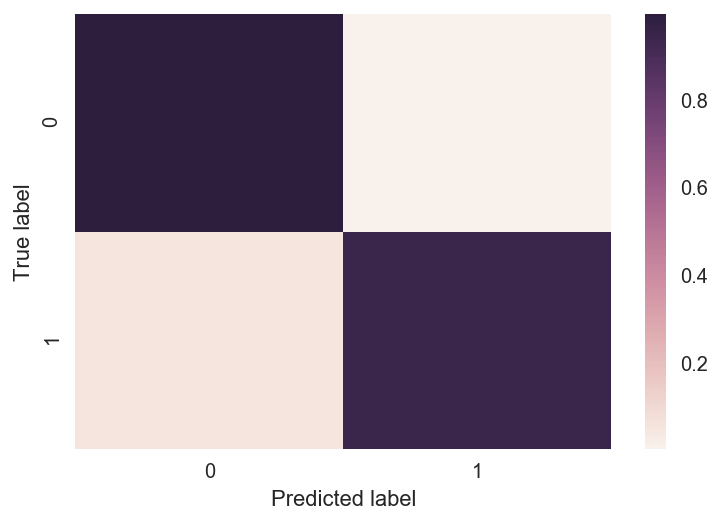

In [116]:
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Future works

In [117]:
print(conf_mat)

[[960   5]
 [  8 142]]


In [118]:
pd.set_option('display.max_colwidth', -1)

#### Misclassified as Spam

In [122]:
X_test[y_test < prediction['Multinomial']]

573     Waiting for your call.                                                                                                      
4727    I (Career Tel) have added u as a contact on INDYAROCKS.COM to send FREE SMS. To remove from phonebook - sms NO to  &lt;#&gt;
5475    Dhoni have luck to win some big title.so we will win:)                                                                      
4860    Nokia phone is lovly..                                                                                                      
1259    We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us                           
Name: text, dtype: object

#### Misclassfied as Ham

In [120]:
X_test[y_test > prediction['Multinomial']]

5035    You won't believe it but it's true. It's Incredible Txts! Reply G now to learn truly amazing things that will blow your mind. From O2FWD only 18p/txt       
2574    Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one vid is not enough for 2day text back the keyword PICSFREE1 to get the next video.   
3130    LookAtMe!: Thanks for your purchase of a video clip from LookAtMe!, you've been charged 35p. Think you can do better? Why not send a video in a MMSto 32323.
68      Did you hear about the new \Divorce Barbie\"? It comes with all of Ken's stuff!"                                                                            
2662    Hello darling how are you today? I would love to have a chat, why dont you tell me what you look like and what you are in to sexy?                          
4211    Missed call alert. These numbers called but left no message. 07008009200                                                                                    
3572    Yo